# ChatGPT experiments


### Task

an LLM driven prototype that can answer questions based on financial documents (texts, tables, figures etc.). The dataset we'd like you to use is the train.json in the ConvFinQA dataset.

In [9]:

import os
from openai import OpenAI
from openai import OpenAIError
import json
import pandas as pd
from langchain_core.prompts import PromptTemplate
from pprint import pprint
from pathlib import Path
from utils import *

# instructor and pydantic
import instructor
from pydantic import BaseModel, Field
from typing import Iterable, Literal
from typing import List, Optional, Union
from graphviz import Digraph
from dotenv import load_dotenv
import enum

%load_ext autoreload
%autoreload 2

# Load the environment variables
from dotenv import load_dotenv
load_dotenv()


True

In [10]:
# prompts
system_prompt = """ I am a highly intelligent bot. I can have conversations with the user to
answer a series of questions. Later questions may depend on previous questions to answer. You need
to provide me with the series of questions as the context and I will answer the last question.
"""

prompt_template = PromptTemplate.from_template(
    "Answer the following questions using the context provided:\ncontext: {context} \nquestions:\n{questions} \nanswer: {answer}"
)


In [111]:
def get_q_category(q_type:str, q_diff:dict)->str:
    """
    Create a difficulty category for the question based on the type of question and the difficulty level
    args:
    q_type: str: Type of question
    q_difficulty: dict: Difficulty level of the question based on the number of steps required to solve the question
       
    return:
    str: Difficulty category

    example
    get_difficulty_category("Type I", {0:1}) -> "S10"
    get_difficulty_category("Type II", {0: 2, 1: 5}) -> "H25"
    """
 
    return f"{'S' if q_type=='Type I' else 'H'}{q_diff.get(0,0)}-{q_diff.get(1,0)}"


In [128]:
# load data set
fpath = Path('../data/ConvFinQA/data/train.json')
data = pd.DataFrame(json.load(fpath.open()))

usecols = ['q', 'q_type', 'q_difficulty', 'q_category', 'q_chain', 'a_chain', 'answer_0', 
           'exe_ans_0', 'answer_1', 'exe_ans_1','pre_text', 'post_text',  'table_ori', 'table', 'annotation']

# flatten the annotation column and extract question chains
data['q_type'] = data['id'].map(lambda x: 'Type I' if 'Single' in x  else 'Type II')  # get question type
data['q_difficulty'] = data.annotation.map(get_difficulty)                            # get question difficulty
data['q_category'] = data.apply(lambda x: get_q_category(x.q_type, x.q_difficulty), axis=1)        # get question difficulty category
data['q'] = data.apply(get_q, axis=1)                                                 # get top level question
data['q_chain'] = data.apply(lambda x: x['annotation']['dialogue_break'], axis=1)     # get question chain

# flatten the annotation column and extract answer chains
data['a_chain'] = data.apply(lambda x: x['annotation']['exe_ans_list'], axis=1)       # get answer chain
data['answers'] = data.apply(get_a, axis=1)                                           # get answer
data['answer_0'] = data.answers.map(lambda x: x.get('answer_0').strip())              # answer
data['exe_ans_0'] = data.answers.map(lambda x: x.get('exe_ans_0'))                    # execution answer
data['answer_1'] = data.answers.map(lambda x: x.get('answer_1', '').strip())          # answer
data['exe_ans_1'] = data.answers.map(lambda x: x.get('exe_ans_1'))                    # execution answer
                  
data[usecols].head()

,q,q_type,q_difficulty,q_category,q_chain,a_chain,answer_0,exe_ans_0,answer_1,exe_ans_1,pre_text,post_text,table_ori,table,annotation
0,{'question_0': 'what was the percentage change...,Type I,{0: 4},S4-0,[what is the net cash from operating activitie...,"[206588.0, 181001.0, 25587.0, 0.14136]",14.1%,0.14136,,None,"[26 | 2009 annual report in fiscal 2008 , reve...","[year ended june 30 , cash provided by operati...","[[, Year ended June 30, 2009], [2008, 2007], [...","[[2008, year ended june 30 2009 2008, year end...",{'amt_table': '<table class='wikitable'><tr><t...
1,{'question_0': 'what was the percent of the gr...,Type I,{0: 4},S4-0,"[what were revenues in 2008?, what were they i...","[9362.2, 9244.9, 117.3, 0.01269]",1.3%,0.01269,,None,[substantially all of the goodwill and other i...,[the above unaudited pro forma financial infor...,"[[, Year Ended December 31, 2008 (Unaudited), ...","[[, year ended december 31 2008 ( unaudited ),...",{'amt_table': '<table class='wikitable'><tr><t...
2,{'question_0': 'what was the percentage change...,Type I,{0: 4},S4-0,"[what was the total of net sales in 2001?, and...","[5363.0, 7983.0, -2620.0, -0.3282]",-32%,-0.3282,,None,[in a new business model such as the retail se...,[.],"[[, 2002, 2001, 2000], [Net sales, $5,742, $5,...","[[, 2002, 2001, 2000], [net sales, $ 5742, $ 5...",{'amt_table': '<table class='wikitable'><tr><t...
3,{'question_0': 'what was the difference in per...,Type I,{0: 6},S6-0,[what was the change in the performance of the...,"[-24.05, -0.2405, 102.11, 2.11, 0.0211, -0.2616]",-26.16%,-0.2616,,None,[( 1 ) includes shares repurchased through our...,[.],"[[, 12/31/04, 12/31/05, 12/31/06, 12/31/07, 12...","[[, 12/31/04, 12/31/05, 12/31/06, 12/31/07, 12...",{'amt_table': '<table class='wikitable'><tr><t...
4,{'question_0': 'what is the roi of an investme...,Type II,"{0: 2, 1: 5}",H2-5,[what was the fluctuation of the performance p...,"[-8.94, -0.0894, -24.05, -0.2405, 2.11, 0.0211...",-8.9%,-0.0894,-26.16%,-0.2616,[( 1 ) includes shares repurchased through our...,[.],"[[, 12/31/04, 12/31/05, 12/31/06, 12/31/07, 12...","[[, 12/31/04, 12/31/05, 12/31/06, 12/31/07, 12...",{'amt_table': '<table class='wikitable'><tr><t...


<Axes: title={'center': 'Question Difficulty Category Distribution'}, xlabel='q_category'>

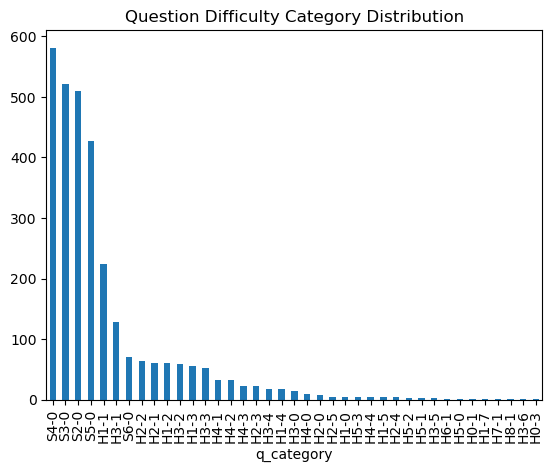

In [122]:
data.q_category.value_counts().plot(kind='bar', title='Question Difficulty Category Distribution')

In [123]:
# Create base model for multiple hop QA

class AmountType(str, enum.Enum):
    """Enumeration representing the types of numerical amounts that can be used in an answer."""
    PERCENT = "PERCENT"
    NET_AMOUNT = "NET_AMOUNT"
    OTHER = "OTHER"


class OperationType(str, enum.Enum):
    """Enumeration representing the types of operations that can be used in an answer."""
    ADD = "add"
    SUBTRACT = "subtract"
    MULTIPLY = "multiply"
    DIVIDE = "divide"
    EXP = "exp"
    GREATER = "greater"
    ASK_FOR_NUMBER = "Ask for number"


class Operation(BaseModel):
    """Class representing a single operation in an answer list"""

    operation: str = Field(
        ...,
        description=("Operation used to calculate the answer for example: add, multiply, subtract, divide, exp, greater. format as operation(arg1, arg2). "
                     "examples: add(10, 20), ask_for_number(arg1), divide(2000, 120)"
                     "Leave percentage calculations as decimals ie do not multiply by 100"
                     "if the operation is a query on the text to retrieve an amount then format as: Ask for number arg1"
                ),
    )
    operation_type: OperationType = Field(
        description="Operation used to calculate the answer for example: add, multiply, subtract, divide, exp, greater.",
    )

    arg1: str = Field(
        description="the first number used by the operation",
    )
    arg2: Optional[str] = Field(
        description="the second number used by the operation",
    )

    def __str__(self):
        return f"{self.operation_type.value}({self.arg1}, {self.arg2})"


class Answer(BaseModel):
    """Class representing a single answer in an answer list"""

    id: int = Field(..., description="Unique id of the answer")
    question: str = Field(
        ...,
        description="Question asked using a question answering system",
    )
    explanation: str = Field(
        ...,
        description="Explanation of the answer and the calculation",
    )
    amount: float = Field(
        ...,
        description="Amount of the answer",
    )
    operation: Operation = Field(
        ...,
        description=("Operation used to calculate the answer for example: add, multiply, subtract, divide, exp, greater. format as operation(arg1, arg2). "
                     "for example: add(10, 20). "
                     "Leave percentage calculations as decimals ie do not multiply by 100"
                     "if the operation is a query on the text to retrieve an amount then format as: Ask for number arg1"
                    
                ),
    )
    dependencies: List[int] = Field(
        default_factory=list,
        description="List of ids of any previous answers that need to be calculated before this answer can be calculated",
    )
    amount_type: AmountType = Field(
        ...,
        description="Type of amount asked for the question, either a net amount or a percent or other",
    )


class AnswerList(BaseModel):
    """Container class representing a tree of questions to ask a question answering system."""

    answer_list: List[Answer] = Field(
        ..., description="The list of answers"
    )

    # todo
    def _dependencies(self, ids: List[int]) -> List[Answer]:
        """Returns the dependencies of a query given their ids."""
        return [q.id for q in self.answer_list if q.id in ids]



In [124]:
client = instructor.from_openai(OpenAI())
def structuredQA(system_prompt: str, user_prompt:str, model = "gpt-4o-mini", client=client) -> AnswerList:
    """ 
    Format the response from the model into a structured answer list using a custom pydanctic model AnswerList
    
    args:
    system_prompt: str: system prompt
    user_prompt: str: user prompt
    model: str: model to use for the completion
    return:
    AnswerList: list of answers
    """

    messages = [ { "role": "system", "content": system_prompt}, 
                 { "role": "user", "content": user_prompt}]
    answers_list = client.chat.completions.create_with_completion(
        model=model,
        temperature=0,
        response_model=AnswerList,
        messages=messages,
        max_tokens=1000,
    )
    return answers_list

In [129]:
model = "gpt-4o-mini"
n = 10

df = data.iloc[:n].copy()
df

AttributeError: 'list' object has no attribute 'iloc'

In [126]:

df['model'] = model
df['context'] = df.apply(lambda x: f"{x['pre_text']} {x['table']} {x['post_text']}", axis=1)                                              #context from base fields
df['context2'] = df.annotation.map(lambda x: f"{x.get('amt_pre_text', '')} {x.get('amt_table', '')} {x.get('amt_post_text', '')}")        # context from annotations ? 
df['questions'] = df.annotation.map(lambda x:  '\n'.join([f'Q{j}: {s}' for j, s in enumerate(x['dialogue_break'])]))
df['gt_amt'] = df.annotation.map(lambda x: x.get('exe_ans_list', []))
df['step_list'] = df.annotation.map(lambda x: x.get('step_list', []))

# create prompt and call llm
df['user_prompt'] = df.apply(lambda x: prompt_template.format(context=x['context'], questions=x['questions'], answer=""), axis=1)
df['llm_answers'], df['completion'] = zip(*df.apply(lambda x: structuredQA(system_prompt, x['user_prompt'], model), axis=1))
df['completion'] = df.completion.map(lambda x: x.dict())
df['response'] = df.llm_answers.map(lambda x: x.answer_list)

# score the answers
df['eval'] = df.apply(lambda x: score_answers(x.response, x.gt_amt, x.step_list), axis=1)

# ...
df['response_ans_list'] = df.response.map(lambda x: [a.amount for a in x])
df['exe_answer'] = df.response.map(lambda x: x[-1].amount)


# extract the results
rescols = ['id', 'q', 'q_category', 'context', 'questions', 'user_prompt', 'response', 'response_ans_list',
           'gt_amt', 'step_list', 'exe_answer', 'model']

# concat the results, evaluation scores, and the completion token counts
llm_res = pd.concat([df[rescols].copy(), 
                     df['eval'].apply(pd.Series), 
                     df.completion.apply(pd.Series)['usage'].apply(pd.Series)], 
                     axis=1)

# save results and run evaluation
save_results(llm_res)
run_eval = evaluate_run_results(llm_res)


display(llm_res.head())
print(run_eval)



,id,q,q_category,context,questions,user_prompt,response,response_ans_list,gt_amt,step_list,exe_answer,model,exe_ans_score,retrieval_score,exe_ans,step_score,df,completion_tokens,prompt_tokens,total_tokens
0,Single_JKHY/2009/page_28.pdf-3,{'question_0': 'what was the percentage change...,S4-0,"['26 | 2009 annual report in fiscal 2008 , rev...",Q0: what is the net cash from operating activi...,Answer the following questions using the conte...,[id=0 question='what is the net cash from oper...,"[206588.0, 181001.0, 25587.0, 0.1415]","[206588.0, 181001.0, 25587.0, 0.14136]","[Ask for number 206588, Ask for number 181001,...",0.1415,gpt-4o-mini,0.75,1.0,0,0.25,id type operation ...,784,4123,4907
1,Single_RSG/2008/page_114.pdf-2,{'question_0': 'what was the percent of the gr...,S4-0,['substantially all of the goodwill and other ...,Q0: what were revenues in 2008?\nQ1: what were...,Answer the following questions using the conte...,[id=0 question='what were revenues in 2008?' e...,"[9362.2, 9244.9, 117.3, 0.0127]","[9362.2, 9244.9, 117.3, 0.01269]","[Ask for number 9362.2, Ask for number 9244.9,...",0.0127,gpt-4o-mini,0.75,1.0,0,0.25,id type operation...,784,3519,4303


{'exe_ans_score': 0.75, 'retrieval_score': 1.0, 'exe_ans': 0.0, 'step_score': 0.25, 'total_completion_tokens': 1568, 'total_prompt_tokens': 7642, 'total_tokens': 9210, 'average_tokens': 4605.0}
